In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from typing import Any, Iterable
import wandb

import block_formats.experiments as E

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

In [2]:
API = wandb.Api()

def load_stats(run: wandb.apis.public.Run) -> Iterable[dict[str, Any]]:
    if "weight_stats" in run.summary:
        model = run.config["model"].split("/")[1]
        for w, d in run.summary["weight_stats"].items():
            d = dict(model=model, weight=w, **d)
            for dist, stats in d.pop("fit").items():
                for k, v in stats.items():
                    d[f"{dist}_{k}"] = v
            yield d

df = pd.DataFrame.from_records([s for run in API.runs("graphcore/sparse-attention-formats", {"config.experiment": "20250312-weight-stats"}) for s in load_stats(run)])
df["ukurt"] = (df["rm4"] / df["rm2"])**4
df["rank"] = df["shape"].apply(len)
df["max_over_rm2"] = df["max"] / df["rm2"]
df["ptail3"] = df["hist"].apply(lambda h: sum(h[3:]))
df["ptail4"] = df["hist"].apply(lambda h: sum(h[4:]))
df["ptail5"] = df["hist"].apply(lambda h: sum(h[5:]))

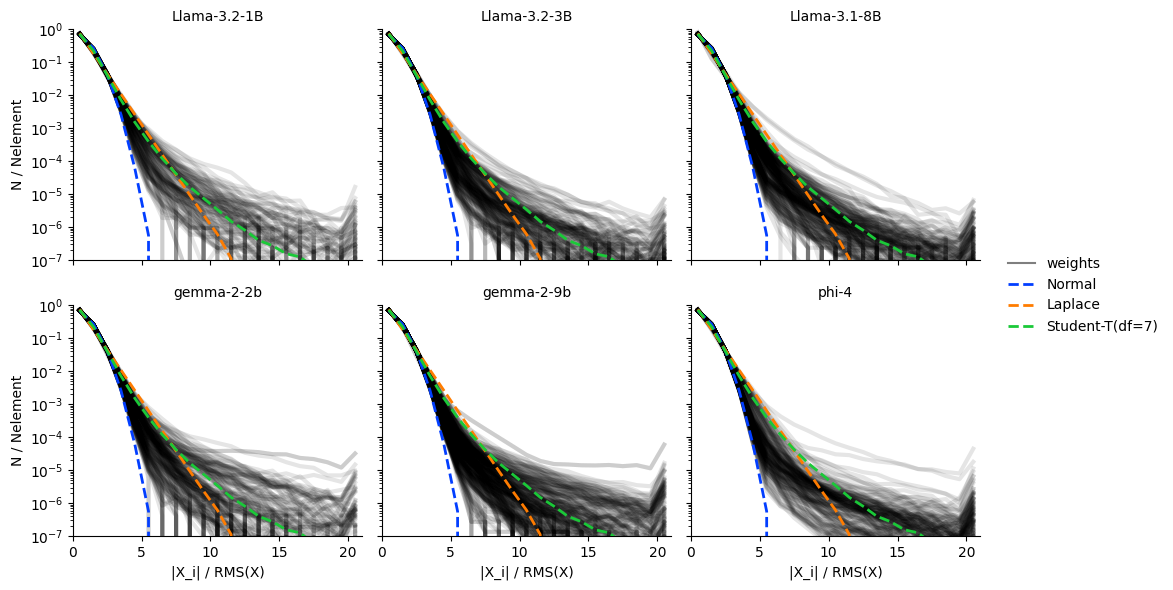

In [10]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 6), sharex=True, sharey=True)

bins = torch.arange(1, 20 + 1)
xbins = torch.cat([bins, torch.tensor([21])]) - 0.5
studentt_df = 7
n_samples = 2**27

dist_data = {name: E._scaled_hist(t, bins, dim=None) for name, t in {
    "Normal": torch.randn(n_samples),
    "Laplace": torch.distributions.Laplace(0., 1.).sample((n_samples,)),
    f"Student-T(df={studentt_df})": torch.distributions.StudentT(studentt_df).sample((n_samples,)),
}.items()}

for ax, model in zip(axs.flatten(), df.model.unique()):
    for _, d in df[(df["model"] == model) & (df["rank"] == 2)].iterrows():
        ax.plot(xbins, d["hist"], **(dict(color="r", zorder=100) if d["StudentT_df"] < 0 else dict(color="k", alpha=.1, lw=3)))
    for (name, h), color in zip(dist_data.items(), sns.color_palette("bright")):
        ax.plot(xbins, h, ls="--", lw=2, zorder=101, label=name, color=color)
    ax.set_title(model, fontsize=10)
    ax.set_yscale("log")
    ax.set_ylim((10**-7, 1))
    ax.set_xlim((0, 21))

for ax in axs[:, 0]:
    ax.set_ylabel(r"N / Nelement")
for ax in axs[-1, :]:
    ax.set_xlabel(r"|X_i| / RMS(X)")

h, _ = axs[0, 0].get_legend_handles_labels()
h.insert(0, matplotlib.lines.Line2D([], [], color="k", alpha=.5, label="weights"))
fig.legend(handles=h, bbox_to_anchor=(1, 0.5), loc="center left")
fig.tight_layout()

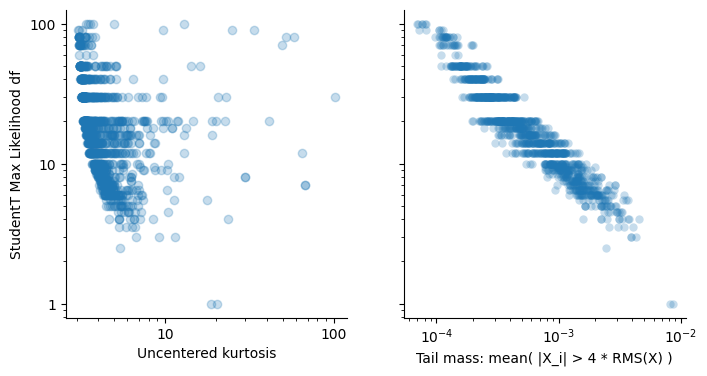

In [8]:
d = df[df["rank"] == 2]
_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)
ax0.scatter(d["ukurt"], d["StudentT_df"], alpha=.25)
ax0.set_xlabel("Uncentered kurtosis")
ax0.set_ylabel("StudentT Max Likelihood df")

ax1.scatter(d["ptail4"], d["StudentT_df"], alpha=.25, lw=0)
ax1.set_xlabel("Tail mass: mean( |X_i| > 4 * RMS(X) )")
for ax in (ax0, ax1):
    ax.set_yscale("log")
    ax.set_xscale("log")
ax0.xaxis.set_major_formatter("{x:.0f}")
ax0.yaxis.set_major_formatter("{x:.0f}")